# Option 2

Loading data...
Total units: 8; donors: 7
Using 50 DE seeds (example: [np.int64(82116), np.int64(83236), np.int64(15076), np.int64(67582), np.int64(64683)])

--- Running treated unit ---
  tried 1/50 seeds; current best fun=0.132804 (seed=82116)
  tried 10/50 seeds; current best fun=0.042663 (seed=12616)
  tried 20/50 seeds; current best fun=0.042663 (seed=12616)
  tried 30/50 seeds; current best fun=0.042663 (seed=12616)
  tried 40/50 seeds; current best fun=0.042663 (seed=12616)
  tried 50/50 seeds; current best fun=0.042663 (seed=12616)

Predictor balance (treated vs synthetic) [STANDARDIZED]:
Predictor                         Treated    Synthetic       Diff
----------------------------------------------------------------------
E_eubadIP_1979_1994                1.6909      -0.2420     1.9329
E_NatDem_satisfiedIP_1979_1994    -0.1361       0.0923    -0.2284
unempIP_1979_1994                 -0.0196      -0.0164    -0.0033
opencIP_1979_1994                 -0.6570       0.3590    -1.

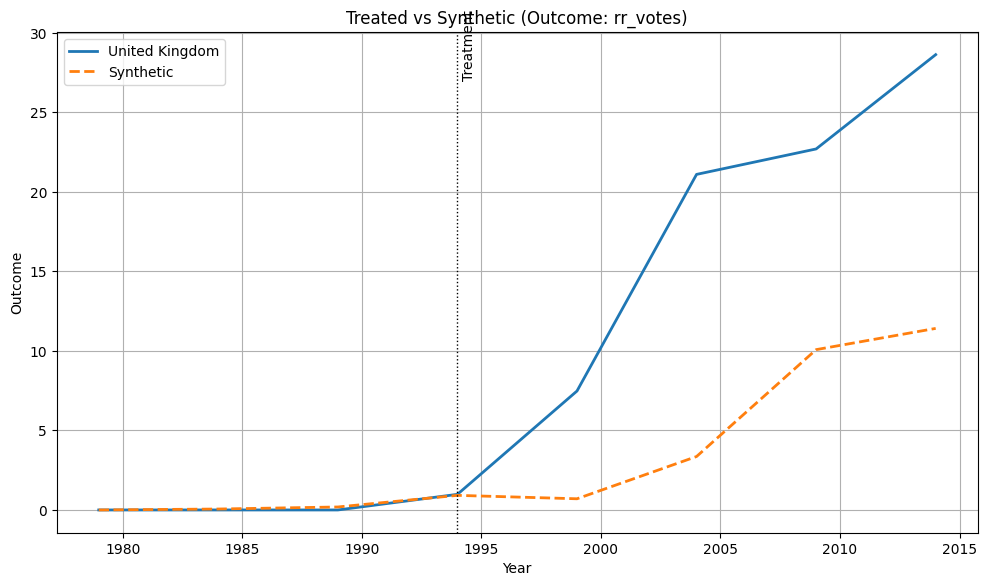

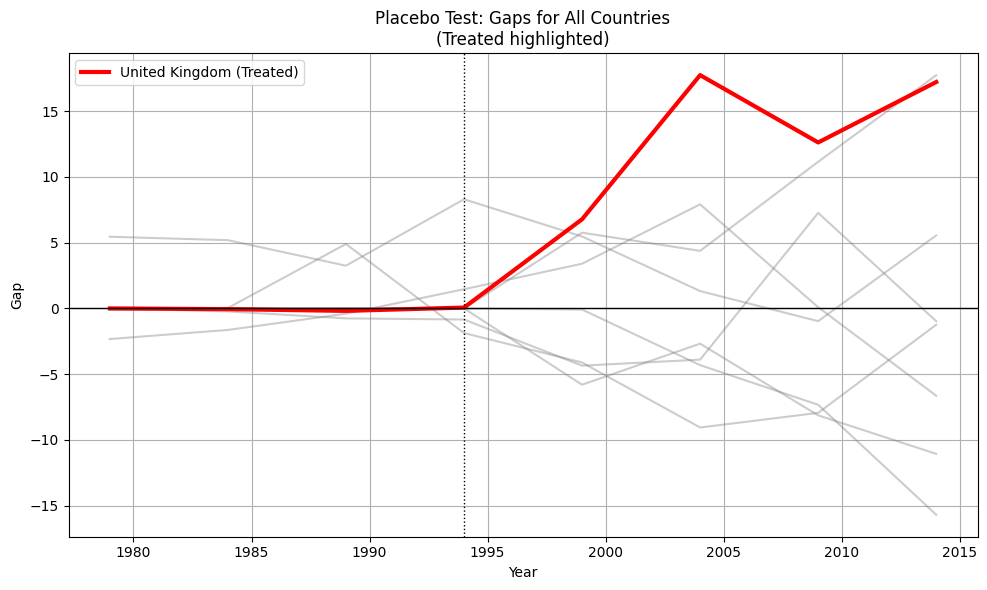

In [2]:
"""
mscmt_nnls_de.py

MSCMT-style synthetic control:
- Outer optimizer: differential_evolution (multiple seeds; best kept)
- Inner optimizer: NNLS (nonnegative least squares) on sqrt(V)-weighted predictors, normalized to sum=1
- Predictors: covariate means over windows + single-year rr_votes lag (1994)
- Placebo tests and permutation p-values like your R script
- Data loaded via pyreadstat from Stata .dta files
"""

import time
import pickle
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import pyreadstat
from scipy.optimize import differential_evolution, nnls
import matplotlib.pyplot as plt

# -------------------------
# Data loading / shaping
# -------------------------
def load_and_prepare_data(path_main="replication/CountryEPData.dta", path_cov="replication/CountryEPData_covIP.dta"):
    dat, _ = pyreadstat.read_dta(path_main)
    dat = dat[~dat['ccode'].isin([5, 6, 9, 12])]
    dat = dat[dat['ep_election'] != 2019]
    datIP, _ = pyreadstat.read_dta(path_cov)
    dat = dat.merge(datIP, on=['ccode', 'year', 'ep_election'])
    cols = ["rr_votes", "E_eubadIP", "E_NatDem_satisfiedIP", "unempIP", "opencIP",
            "S_uegenIP", "rightgovIP", "ch_imp_fns", "eu_pos_meanIP", "migr_inflIP",
            "ccode", "country", "ep_election", "year"]
    dat = dat[cols]
    return dat

def long_to_wide(dat: pd.DataFrame, unit_name_var='country', time_var='ep_election'):
    countries = sorted(dat[unit_name_var].unique().tolist())
    dat_unique = dat.groupby([unit_name_var, time_var]).first().reset_index()
    data_dict = {}
    var_cols = [c for c in dat.columns if c not in ['ccode', unit_name_var, time_var, 'year']]
    for var in var_cols:
        wide = dat_unique.pivot(index=time_var, columns=unit_name_var, values=var)
        wide = wide.reindex(columns=countries)
        data_dict[var] = wide
    return data_dict, countries, sorted(dat[time_var].unique())

# -------------------------
# Predictor construction (MSCMT-style)
# -------------------------
def build_predictors_mscmt(data_dict: Dict[str, pd.DataFrame],
                           unit: str,
                           donors: List[str],
                           times_pred: Dict[str, Tuple[int,int]]):
    X1_rows = []
    X0_rows = []
    names = []
    for var, (start_year, end_year) in times_pred.items():
        df = data_dict[var]
        if start_year == end_year:
            y = start_year
            if y not in df.index:
                raise KeyError(f"{var} year {y} not in index")
            X1_rows.append(np.array([df.loc[y, unit]]).reshape(1,1))
            X0_rows.append(df.loc[y, donors].values.reshape(1, -1))
            names.append(f"{var}_{int(y)}")
        else:
            mask = (df.index >= start_year) & (df.index <= end_year)
            df_period = df[mask]
            if df_period.shape[0] == 0:
                raise KeyError(f"{var} has no years in window {start_year}-{end_year}")
            X1_rows.append(np.array([df_period[unit].mean()]).reshape(1,1))
            X0_rows.append(df_period[donors].mean(axis=0).values.reshape(1, -1))
            names.append(f"{var}_{start_year}_{end_year}")
    X1 = np.vstack(X1_rows)   # (K,1)
    X0 = np.vstack(X0_rows)   # (K,J)
    return X1, X0, names

def standardize_predictors_pooled(X1: np.ndarray, X0: np.ndarray):
    K, J = X0.shape
    means = np.zeros(K)
    stds = np.ones(K)
    for i in range(K):
        pooled = np.concatenate(([X1[i,0]], X0[i,:]))
        m = np.nanmean(pooled)
        s = np.nanstd(pooled, ddof=0)
        if s <= 0 or np.isnan(s):
            s = 1.0
        means[i] = m
        stds[i] = s
        X1[i,0] = (X1[i,0] - m) / s
        X0[i,:] = (X0[i,:] - m) / s
    return X1, X0, means, stds

# -------------------------
# Outcomes helper
# -------------------------
def extract_outcomes(data_dict, unit, donors, outcome_var, times_dep):
    df = data_dict[outcome_var]
    start_year, end_year = times_dep
    mask = (df.index >= start_year) & (df.index <= end_year)
    df_period = df[mask]
    Z1 = df_period[unit].values.reshape(-1,1)
    Z0 = df_period[donors].values
    return Z1, Z0

# -------------------------
# Inner optimizer: NNLS + normalization
# -------------------------
def solve_W_nnls(X0: np.ndarray, X1: np.ndarray, V_diag: np.ndarray):
    """
    Solve NNLS on sqrt(V)*X0 and sqrt(V)*X1, then normalize weights to sum 1.
    Returns w (J,)
    """
    sqrtV = np.sqrt(np.maximum(V_diag, 1e-12)).reshape(-1,1)  # (K,1)
    A = sqrtV * X0   # (K,J)
    b = (sqrtV * X1).flatten()  # (K,)
    # Use scipy.nnls (fast)
    try:
        w_nonneg, _ = nnls(A, b)
    except Exception:
        # fallback uniform
        J = X0.shape[1]
        return np.ones(J) / J
    if w_nonneg.sum() <= 1e-12:
        J = X0.shape[1]
        return np.ones(J) / J
    return w_nonneg / w_nonneg.sum()

# -------------------------
# Robust DE objective using NNLS inner solver
# -------------------------
def loss_V_nnls_safe(V_raw: np.ndarray, X0: np.ndarray, X1: np.ndarray, Z0: np.ndarray, Z1: np.ndarray,
                     large_penalty: float = 1e18):
    """
    DE objective: normalize V_raw -> V_norm, compute W via NNLS, return SSE on pre-treatment outcomes.
    Robust: any numerical error -> large_penalty.
    """
    try:
        Vpos = np.maximum(V_raw, 1e-12)
        Vnorm = Vpos / (np.sum(Vpos) + 1e-18)
        Wopt = solve_W_nnls(X0, X1, Vnorm)
        synthetic_Z = Z0 @ Wopt.reshape(-1,1)
        err = Z1 - synthetic_Z
        sse = float(np.sum(err**2))
        if not np.isfinite(sse):
            return large_penalty
        return sse
    except Exception:
        return large_penalty

# -------------------------
# Run DE across many seeds and keep best
# -------------------------
def optimize_V_with_seeds_nnls(X0: np.ndarray, X1: np.ndarray, Z0: np.ndarray, Z1: np.ndarray,
                               seeds: List[int], bounds=None,
                               de_maxiter: int = 80, de_popsize: int = 8):
    K = X1.shape[0]
    if bounds is None:
        bounds = [(1e-9, 1e6)] * K
    best_fun = np.inf
    best_x = None
    best_seed = None

    for i, s in enumerate(seeds):
        try:
            res = differential_evolution(
                func=lambda v: loss_V_nnls_safe(v, X0, X1, Z0, Z1),
                bounds=bounds,
                seed=int(s),
                maxiter=de_maxiter,
                popsize=de_popsize,
                tol=1e-6,
                atol=1e-8,
                mutation=(0.5, 1.0),
                recombination=0.6,
                updating='deferred',
                polish=True,
                workers=1
            )
        except Exception as e:
            print(f"  DE seed {s} raised exception: {e}; continuing.")
            continue

        if not np.isfinite(res.fun):
            print(f"  DE seed {s} returned non-finite objective: {res.fun}; skipping.")
            continue

        if res.fun < best_fun:
            best_fun = float(res.fun)
            best_x = res.x.copy()
            best_seed = int(s)

        if (i+1) % 10 == 0 or i == 0:
            print(f"  tried {i+1}/{len(seeds)} seeds; current best fun={best_fun:.6g} (seed={best_seed})")

    if best_x is None:
        raise RuntimeError("All DE runs failed or returned invalid results. Try widening bounds or reducing DE complexity.")

    Vpos = np.maximum(best_x, 1e-12)
    Vnorm = Vpos / (np.sum(Vpos) + 1e-18)
    return Vnorm, best_fun, best_seed

# -------------------------
# Run MSCMT (NNLS inner) for one unit
# -------------------------
def run_unit_nnls(unit: str, data_dict: Dict[str, pd.DataFrame], units_all: List[str],
                  times_pred: Dict[str, Tuple[int,int]], times_dep: Tuple[int,int],
                  seeds: List[int], de_maxiter: int = 80, de_popsize: int = 8, quiet: bool = False):
    controls = [u for u in units_all if u != unit]
    # Build predictors and standardize
    X1, X0, predictor_names = build_predictors_mscmt(data_dict, unit, controls, times_pred)
    X1, X0, means, stds = standardize_predictors_pooled(X1, X0)
    # Pre-treatment outcomes
    Z1, Z0 = extract_outcomes(data_dict, unit, controls, "rr_votes", times_dep)

    # Optimize V via DE across seeds, keep best
    V_hat, best_fun, best_seed = optimize_V_with_seeds_nnls(X0, X1, Z0, Z1, seeds,
                                                            bounds=[(1e-9,1e6)]*X1.shape[0],
                                                            de_maxiter=de_maxiter, de_popsize=de_popsize)
    # Final W via NNLS
    W_hat = solve_W_nnls(X0, X1, V_hat)

    # Full timeseries synthetic
    df_full = data_dict["rr_votes"]
    years_all = df_full.index.values
    y1_full = df_full[unit].values
    donors_full = df_full[controls].values
    synthetic_full = donors_full @ W_hat

    synthetic_Z = Z0 @ W_hat.reshape(-1,1)

    return {
        "unit": unit,
        "predictors": predictor_names,
        "means": means,
        "stds": stds,
        "X1": X1, "X0": X0,
        "V": V_hat, "W": W_hat,
        "Z1": Z1, "Z0": Z0,
        "synthetic_Z": synthetic_Z,
        "full_years": years_all,
        "y1_full": y1_full, "synthetic_full": synthetic_full,
        "best_fun": best_fun, "best_seed": best_seed
    }

# -------------------------
# Main script
# -------------------------
if __name__ == "__main__":
    t0 = time.time()
    print("Loading data...")
    dat = load_and_prepare_data()
    data_dict, countries, times = long_to_wide(dat)

    treatment_id = "United Kingdom"
    if treatment_id not in countries:
        raise KeyError(f"Treated {treatment_id} not found in countries")

    controls_id = [c for c in countries if c != treatment_id]
    print(f"Total units: {len(countries)}; donors: {len(controls_id)}")

    # MSCMT specification
    times_dep = (1979, 1994)
    times_pred = {
        "E_eubadIP": (1979, 1994),
        "E_NatDem_satisfiedIP": (1979, 1994),
        "unempIP": (1979, 1994),
        "opencIP": (1979, 1994),
        "ch_imp_fns": (1979, 1994),
        "S_uegenIP": (1979, 1994),
        "rightgovIP": (1979, 1994),
        "eu_pos_meanIP": (1979, 1994),
        "migr_inflIP": (1984, 1994),
        "rr_votes": (1994, 1994)
    }

    # Seeds - mimic R sampling
    rng = np.random.default_rng(54321)
    n_seeds = 50
    seeds = list(rng.choice(np.arange(4322, 97835), size=n_seeds, replace=False))
    print(f"Using {len(seeds)} DE seeds (example: {seeds[:5]})")

    # Run treated
    print("\n--- Running treated unit ---")
    treated_res = run_unit_nnls(treatment_id, data_dict, countries, times_pred, times_dep,
                                seeds, de_maxiter=80, de_popsize=8, quiet=False)


    # ================================================================
    #  PREDICTOR BALANCE TABLE (STANDARDIZED)
    # ================================================================
    print("\nPredictor balance (treated vs synthetic) [STANDARDIZED]:")
    print(f"{'Predictor':30s} {'Treated':>10s} {'Synthetic':>12s} {'Diff':>10s}")
    print("-" * 70)

    X1 = treated_res["X1"].flatten()
    X0 = treated_res["X0"]
    W = treated_res["W"]
    synthetic_pred = X0 @ W

    for name, t_val, s_val in zip(treated_res["predictors"], X1, synthetic_pred):
        diff = t_val - s_val
        print(f"{name:30s} {t_val:10.4f} {s_val:12.4f} {diff:10.4f}")


    # ================================================================
    #  OUTCOME FIT (PRE-TREATMENT)
    # ================================================================
    print("\nOutcome (pre-treatment) fit:")
    print(f"{'Year':8s} {'Treated':>10s} {'Synthetic':>12s} {'Diff':>10s}")
    print("-" * 50)

    # Build pre-treatment years list from the data_dict index
    df_rr = data_dict['rr_votes']
    years_dep_mask = (df_rr.index >= times_dep[0]) & (df_rr.index <= times_dep[1])
    years_dep_list = df_rr.index[years_dep_mask].tolist()

    Z1 = treated_res["Z1"].flatten()
    Zsyn = (treated_res["Z0"] @ W).flatten()

    for yr, t_val, s_val in zip(years_dep_list, Z1, Zsyn):
        diff = t_val - s_val
        # yr might be numpy.int64; convert to int for formatting
        yr_int = int(yr)
        print(f"{yr_int:<8d} {t_val:10.4f} {s_val:12.4f} {diff:10.4f}")

    errors = Z1 - Zsyn
    rmspe = np.sqrt(np.mean(errors**2))
    print(f"\nRMSPE (pre-treatment): {rmspe:.4f}")


    # ================================================================
    #  SAVE FULL GAP SERIES FOR PLOTTING (needed later)
    # ================================================================
    treated_full = treated_res["y1_full"]
    synthetic_full_treated = treated_res["synthetic_full"]
    years_all = treated_res["full_years"]
    gap_treated = treated_full - synthetic_full_treated


    # Print W (donor weights) and V (moved after balance table for neatness)
    donors = [c for c in countries if c != treatment_id]
    print("\nTREATED W (non-zero entries):")
    for i, d in enumerate(donors):
        if treated_res["W"][i] > 1e-6:
            print(f"  {d:25s}: {treated_res['W'][i]:.4f}")
    print("\nTREATED V (predictor importances):")
    for i, name in enumerate(treated_res["predictors"]):
        print(f"  {name:30s}: {treated_res['V'][i]:.6f}")


    # Placebo runs (exclude treated)
    print("\n--- Running placebos ---")
    placebo_results = []
    for i, unit in enumerate(controls_id):
        print(f"Placebo {i+1}/{len(controls_id)}: {unit}")
        r = run_unit_nnls(unit, data_dict, countries, times_pred, times_dep, seeds,
                          de_maxiter=80, de_popsize=8, quiet=True)
        placebo_results.append(r)

    # Combine results into list with treated first
    res_list = [treated_res] + placebo_results

    # Post-treatment periods and indices
    post_periods = [1999, 2004, 2009, 2014]
    years_all = treated_res["full_years"].tolist()
    post_idx = []
    for y in post_periods:
        if y in years_all:
            post_idx.append(years_all.index(y))
        else:
            raise KeyError(f"Post-treatment year {y} not present in data index")

    # Assemble gaps matrix (rows: treated + placebos)
    n_units = len(res_list)
    gaps = np.full((n_units, len(post_idx)), np.nan)
    for i, r in enumerate(res_list):
        gaps[i, :] = r["y1_full"][post_idx] - r["synthetic_full"][post_idx]

    # Compute p-values like in R script
    J = len(placebo_results)  # number of placebos
    post_p = np.zeros((len(post_idx), 4))
    post_p[:, 0] = post_periods
    post_p[:, 1] = gaps[0, :]
    for j in range(len(post_idx)):
        post_p[j, 2] = np.sum(np.abs(gaps[1:, j]) > np.abs(gaps[0, j])) / J
        post_p[j, 3] = np.sum(gaps[1:, j] > gaps[0, j]) / J

    treated_res["post_p"] = post_p

    # Average post-treatment gap & p-value (one-sided)
    avg = np.nanmean(gaps, axis=1)
    avg_p = np.sum(avg[1:] > avg[0]) / J
    treated_res["avg_p"] = (avg[0], avg_p)

    # Save results
    with open("scm_nnls_de_results.pkl", "wb") as f:
        pickle.dump({"treated": treated_res, "placebos": placebo_results, "post_p": post_p, "avg_info": treated_res["avg_p"]}, f)

    t1 = time.time()
    print(f"\nDone. Elapsed time: {t1 - t0:.1f} seconds")
    print("\nPost-period p-values (year, treated_gap, p_two_sided, p_one_sided):")
    for row in post_p:
        print(f"{int(row[0])}: gap={row[1]:.4f}, p2={row[2]:.4f}, p1={row[3]:.4f}")

    print(f"\nAverage post gap = {treated_res['avg_p'][0]:.4f}, p_avg = {treated_res['avg_p'][1]:.4f}")

    # ================================================================
    #  Compute placebo gaps dictionary for plotting
    # ================================================================
    placebo_gaps = {}
    for r in placebo_results:
        u = r["unit"]
        placebo_gaps[u] = r["y1_full"] - r["synthetic_full"]
    # Add treated to dictionary
    placebo_gaps[treatment_id] = gap_treated

    # ================================================================
    #  Plot 1: Treated vs Synthetic
    # ================================================================
    try:
        plt.figure(figsize=(10,6))

        plt.plot(years_all, treated_full, label=f"{treatment_id}", linewidth=2)
        plt.plot(years_all, synthetic_full_treated, label="Synthetic", linestyle="--", linewidth=2)

        plt.axvline(x=1994, color="black", linestyle=":", linewidth=1)
        plt.text(1994 + 0.2, max(treated_full) * 0.95, "Treatment", rotation=90)

        plt.title("Treated vs Synthetic (Outcome: rr_votes)")
        plt.xlabel("Year")
        plt.ylabel("Outcome")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    # ================================================================
    #  Plot 2: Placebo Gaps
    # ================================================================
    try:
        plt.figure(figsize=(10,6))

        for u, g in placebo_gaps.items():
            if u == treatment_id:
                plt.plot(years_all, g, color="red", linewidth=3, label=f"{u} (Treated)")
            else:
                plt.plot(years_all, g, color="gray", alpha=0.4)

        plt.axhline(0, color="black", linewidth=1)
        plt.axvline(x=1994, color="black", linestyle=":", linewidth=1)

        plt.title("Placebo Test: Gaps for All Countries\n(Treated highlighted)")
        plt.xlabel("Year")
        plt.ylabel("Gap")
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()
    except Exception:
        pass
